In [77]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import matplotlib.patches
from scipy.stats import zscore
from sklearn.decomposition import NMF, PCA
import pyjags

import seaborn as sns
import networkx as nx
import graphviz

In [15]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### Pre-processing mouse data
Given the limited time, here we load **only the healthy** group of mice data, and **only the tree_based clusters**. 

In the future, we can generalize these structure and method to the ibd group and use the temporal clusters.
#### Load healthy group mice data

In [16]:
### load mouse data
# (1) Healthy Group
with open('data/mouse_set_1_data.pkl', 'rb') as handle:
    mouse_set_1 = pickle.load(handle) 

### unfold mouse data
reads = mouse_set_1['reads']
qpcr = mouse_set_1['qpcr']
otu_taxonomy = mouse_set_1['otu_taxonomy']
times = mouse_set_1['times']

### perturbation time periods
high_fat = [22,28.5]
gram_pos = [36,42.5]
gram_neg = [51,57.5]

### Arrange the structure from mouse 2
mouse_id = '2'
mouse_reads_df = reads[mouse_id]
m_total_amount = qpcr[mouse_id]['mean'].values
all_OTU = list(mouse_reads_df.index)

m_reads_values=reads[mouse_id].values
m_reads_values_sum=sum(m_reads_values)

m_all_abs_amount = np.zeros((len(all_OTU), len(times)))
for idx, otu in enumerate(all_OTU):
    these_reads = mouse_reads_df.loc[otu]
    this_relative_abundance = these_reads.values/m_reads_values_sum
    this_abs_abundance = this_relative_abundance * m_total_amount
    
    m_all_abs_amount[idx,:] = this_abs_abundance
    
m_all_abs_amount.shape

(202, 75)

#### Tree_based Cluster memberships

In [7]:
### load cluster membership for each OTU
clusters = pickle.load( open( "data/OTU_dm_kmclusters.p", "rb" ) )
clusters.shape

(202,)

In [8]:
# cluster IDs of the first 10 OTUs
clusters[:10]

array([ 3,  3, 30,  3, 30, 40,  3,  3,  3,  3], dtype=int32)

In [9]:
# check there should only be 3 distinct cluster IDs
print(np.unique(clusters))

[ 3 30 40]


In [10]:
# replace these IDs with 1, 2, 3
clusters_enum = np.where(clusters==3, 1, clusters) 
clusters_enum = np.where(clusters==30, 2, clusters_enum) 
clusters_enum = np.where(clusters==40, 3, clusters_enum) 
clusters_enum[:10]

array([1, 1, 2, 1, 2, 3, 1, 1, 1, 1], dtype=int32)

In [11]:
# check the replaced cluster ID
print(np.unique(clusters_enum))

[1 2 3]


# Bayesian nonparametric model implemented with PyJAGs

As Travis Gibson and Georg Gerber motivated in their paper, "[Robust and Scalable Models of Microbiomoe Dynamics](https://arxiv.org/abs/1805.04591)," there has been intense interest in understanding the dynamics of microbes living in our human bodies in order to develop new therapeutic interventions, i.e. "bugs as drugs." Thus, Travis and Georg introduced a full Bayesian nonparametric model that addresses the main conceptual and practical challenges of studying how microbes change in abundance over time, but this model is fairly difficult to implement with the most currently available data science packages and tools. So in our project, we decided to simplify their model just enough for it to work with PyJAGS, which is what we have learned in this course, and also we modified it so to gain back the purposes of their main contributions and to adapt to our data. Specifically:

- Instead of assigning OTUs to clusters using the Dirichlet Process, we performed the k-medoids clustering algorithm on their bacterial genomic sequences as described in the clustering section (see phylo_clustering.ipynb).
    + Ideally, we want to be able to add the k-medoids clusters as another prior aside from the Dirichlet Process for the cluster assignment step of the model. But PyJAGS does not allow a "mixture of experts" -- the same problem we face when we try to introduce the axuiliary trajectory variable (q) as described in Travis and Georg's paper.
- Instead of introducing an auxiliary trajectory variable (q) to ensure non-negative dynamics (x), we simply generated the dynamics (x) from a truncated normal distribution that restricts the distribution to positive values.
    + _EDIT_: After discussion with Travis, to simplify further we decided to replace the constraint and measurement model entirely with direct absolute abundances calculated prior to fitting the model, rather than updating the reads with qPCR information at each step of the learning.
- We incorporated indicator variables for time-on of the perturbation periods in our data (high-fat diet, gram-positive, and gram-negative antibiotics).

The goal of our model is still to learn the microbial dynamics, but from two separate time series microbe abundance data: those collected from healthy control and those with IBD. Then, we can compare the learned microbial dynamics of the two health states to answer our scientific questions regarding the relationships of the gut microbiome under the different health conditions. However, due to the time constraints of this course project, we are running MCMC Gibbs sampling of our simplified PyJAGS model on only the healthy dataset as a proof of concept. The entire process laid out in this notebook can be easily repeated for the IBD dataset provided more time. Also, note that the microbial dynamics that we learn with this simplified model are at the cluster-level rather than the species-level.

In [53]:
simplifiedModel = """
model{
    
    # Interaction between clusters
    sig_b_2_inv ~ dgamma(0.1,0.1);   # flat prior
    sig_b = sqrt(1/sig_b_2_inv);
    
    for (i in 1:C){
        for (j in 1:C){
            this_b[i,j] ~ dnorm(0, sig_b_2_inv);
            b[i,j] = ifelse(i==j, 0, this_b[i,j]);
        }
    }
    
    # Edge selection
    pi_z ~ dunif(0,1)
    for (i in 1:C){
        for (j in 1:C){
            z[i,j] ~ dbern(pi_z);
        }
    }
    
    # Self interaction
    sig_a_2_inv ~ dgamma(0.1,0.1);   # flat prior
    sig_a = sqrt(1/sig_a_2_inv);
    
    for (i in 1:N){
        a1[i] ~ dnorm(0,sig_a_2_inv);
        a2[i] ~ dnorm(0,sig_a_2_inv);
    }
    
    # Dynamics
    # set up priors
    sig_w_2_inv ~ dgamma(0.1,0.1);   # flat prior
    sig_w = sqrt(1/sig_w_2_inv);
    
    # initialize bzx[k=1,i,j] (this is the first term for interaction term in main dynamics)
    for (i in 1:N){
        for (j in 1:N){
            bzx[1,i,j] = 0;
        }
    }
    
    # prior for effect of each perturbation
    for (i in 1:N){
        P_fat[i] ~ dnorm(0,0.0001);
        P_pos[i] ~ dnorm(0,0.0001);
        P_neg[i] ~ dnorm(0,0.0001);
    }
    
    # main dynamics 
    for (k in (2:K)){
        for (i in 1:N){
            for (j in 1:N){
                bzx[k,i,j] = b[c[i],c[j]]*z[c[i],c[j]]*x[k-1,j];
            }
            # truncated normal
            x[k,i] ~ dnorm(x[k-1,i] + x[k-1,i]*(a1[i] + a2[i]*x[k-1,i] + sum(bzx[k,i,]) + fat[k-1]*P_fat[i] + pos[k-1]*P_pos[i] + neg[k-1]*P_neg[i]), sig_w_2_inv/(times[k]-times[k-1]))T(0,);
        }
    }
    
}"""

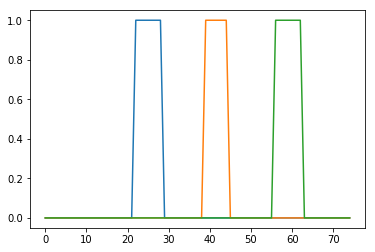

In [54]:
# prepare perturbation as dummy variables
is_high_fat = np.logical_and(np.array(times)>=high_fat[0], np.array(times)<high_fat[1]) 
is_gram_pos = np.logical_and(np.array(times)>=gram_pos[0], np.array(times)<gram_pos[1]) 
is_gram_neg = np.logical_and(np.array(times)>=gram_neg[0], np.array(times)<gram_neg[1]) 

plt.plot(is_high_fat)
plt.plot(is_gram_pos)
plt.plot(is_gram_neg)
plt.show()

In [55]:
observed_vals = {'x': m_all_abs_amount[:20,:35].T,
                 'c': clusters_enum[:20],
                 'times': times[:35],
                 'fat': is_high_fat,
                 'pos': is_gram_pos,
                 'neg': is_gram_neg,
                 'N': 20, # total OTUs
                 'C': 3,  # total clusters
                 'K': len(times[:35])} # total time points

num_chains = 4

model = pyjags.Model(simplifiedModel, data=observed_vals, chains=num_chains)
burnin = model.sample(500)
samples = model.sample(2000)

adapting: iterations 332 of 4000, elapsed 0:00:08, remaining 0:01:33
adapting: iterations 728 of 4000, elapsed 0:00:17, remaining 0:01:18
adapting: iterations 1144 of 4000, elapsed 0:00:27, remaining 0:01:07
adapting: iterations 1568 of 4000, elapsed 0:00:36, remaining 0:00:56
adapting: iterations 2000 of 4000, elapsed 0:00:45, remaining 0:00:45
adapting: iterations 2440 of 4000, elapsed 0:00:54, remaining 0:00:35
adapting: iterations 2888 of 4000, elapsed 0:01:04, remaining 0:00:25
adapting: iterations 3336 of 4000, elapsed 0:01:14, remaining 0:00:15
adapting: iterations 3784 of 4000, elapsed 0:01:24, remaining 0:00:05
adapting: iterations 4000 of 4000, elapsed 0:01:28, remaining 0:00:00
sampling: iterations 240 of 2000, elapsed 0:00:05, remaining 0:00:38
sampling: iterations 472 of 2000, elapsed 0:00:10, remaining 0:00:33
sampling: iterations 700 of 2000, elapsed 0:00:15, remaining 0:00:29
sampling: iterations 924 of 2000, elapsed 0:00:21, remaining 0:00:24
sampling: iterations 1148 

In [56]:
# visualize whether sampler converge
def plot_trace(samples, varname, entry=0):
    plt.plot()
    sample_array = samples[varname]

    vec_len, num_samples, num_chains = sample_array.shape
    for cur_chain in range(num_chains):
        cur_label = "Chain {}".format(cur_chain)
        plt.plot(range(num_samples),sample_array[entry,:,cur_chain], label=cur_label, linewidth = 0.5)
    plt.legend()
    plt.show()

In [ ]:
# load the samples from pickle file
samples = pickle.load( open( "pyjags_samples.p", "rb" ) )

In [57]:
samples.keys()

dict_keys(['C', 'K', 'N', 'P_fat', 'P_neg', 'P_pos', 'a1', 'a2', 'b', 'bzx', 'c', 'fat', 'neg', 'pi_z', 'pos', 'sig_a', 'sig_a_2_inv', 'sig_b', 'sig_b_2_inv', 'sig_w', 'sig_w_2_inv', 'this_b', 'times', 'x', 'z'])

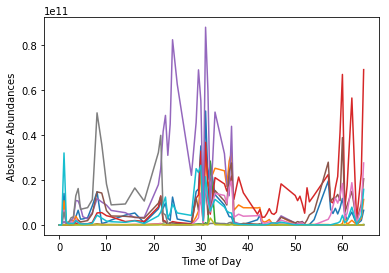

In [70]:
plt.xlabel("Time of Day")
plt.ylabel("Absolute Abundances")
plt.plot(times,np.mean(np.mean(samples['x'],axis= -1),axis=-1))
plt.show()

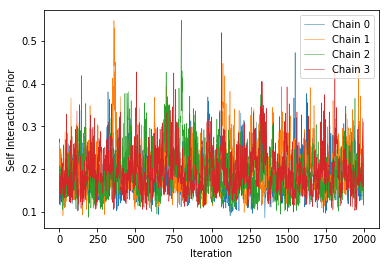

In [61]:
# check MCMC results on self interactions prior (sig_a)
plt.xlabel("Iteration")
plt.ylabel("Self Interaction Prior")
plot_trace(samples,'sig_a')

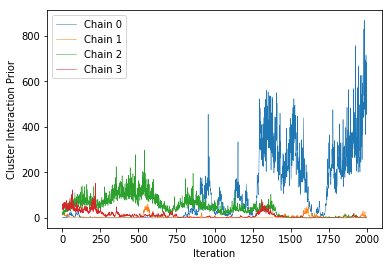

In [62]:
# check MCMC results on cluster interactions prior (sig_b)
plt.xlabel("Iteration")
plt.ylabel("Cluster Interaction Prior")
plot_trace(samples,'sig_b')

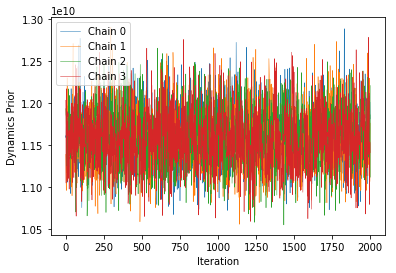

In [63]:
# check MCMC results on dynamics prior (sig_w)
plt.xlabel("Iteration")
plt.ylabel("Dynamics Prior")
plot_trace(samples,'sig_w')

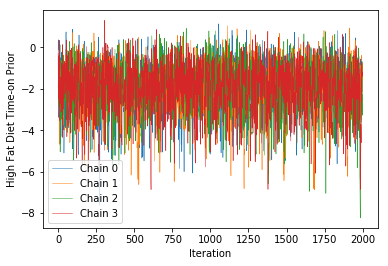

In [64]:
# check MCMC results on high fat diet prior (P_fat)
plt.xlabel("Iteration")
plt.ylabel("High Fat Diet Time-on Prior")
plot_trace(samples,'P_fat')

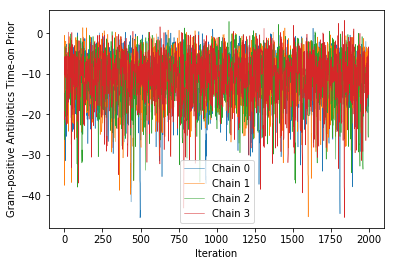

In [65]:
# check MCMC results on gram-positive prior (P_pos)
plt.xlabel("Iteration")
plt.ylabel("Gram-positive Antibiotics Time-on Prior")
plot_trace(samples,'P_pos')

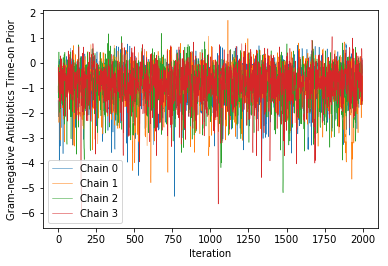

In [66]:
# check MCMC results on gram-negative prior (P_neg)
plt.xlabel("Iteration")
plt.ylabel("Gram-negative Antibiotics Time-on Prior")
plot_trace(samples,'P_neg')

### Interpretations of the learned interaction term

From the model, $b_{c_i, c_j}$ represents the interaction between OTU in cluster $C_i$ with OTU in cluster $C_j$ (i!=j). We learn the value of $b_{c_i, c_j}$ through the model above.

Now, let's visualize them in the network representation, where the **negative correlation** are encoded as **red** arrow, an **positive correlation** are encoded as **green arrow**.
#### (1) Heatmap of the interactions

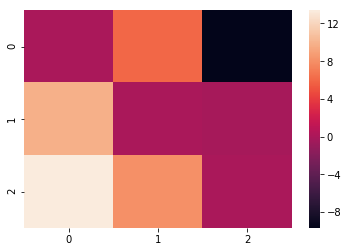

In [23]:
### calculate the correlations of the cluster interactions
b_corr = np.mean(np.mean(samples['b'],axis= -1),axis=-1)

# save the samples from model as a pickle file
# b_corr = pd.read_pickle( "data/pyjags_corr_b.p")

### visualize the interaction matrix
sns.heatmap(b_corr)

#### (2) Network representations of the interaction

Since Networkx doesn't have good support for bi-directional graph, so we plotted the graph in other sofltware, and inserted it here:
<img src="data/b_Network.png" alt="Drawing" style="width: 400px;"/>